# Kay (2012) Figure 7, Panel 2

## Total cloud cover from ISCCP, MISR, and CALIPSO.

### Function and package imports

In [67]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    mpl
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

#### Interpolation functions with xESMF

In [68]:
from interp_functions import *

#### Taylor plot specific imports

In [69]:
import taylor_jshaw as taylor
import matplotlib as matplotlib
import matplotlib.patches as patches

#### Stats specific imports

In [70]:
import scipy.stats as stats

#### Masking imports

In [71]:
import numpy.ma as ma

In [72]:
def get_min_max(da):
    '''
    Requires the file to have identifiable limits/null values.
    '''
    if ('valid_min' in da.attrs and 'valid_max' in da.attrs):
        _min = da.valid_min
        _min_flt = np.float(_min.split(' ')[-1])

        _max = da.valid_max
        _max_flt = np.float(_max.split(' ')[-1])
        
        return _min_flt,_max_flt
        
    elif 'valid_range' in da.attrs:       
        _min_flt = da.valid_range[0]
        _max_flt = da.valid_range[1]
    
        return _min_flt,_max_flt

In [73]:
def get_mask(da):
    '''
    Return values to mask (i.e. to use with where() after inverting).
    Requires the file to have identifiable limits/null values.
    '''
    
    _min,_max = get_min_max(da)

    # these values are True if they should be discarded, should catch Nans
    mask = np.invert(np.bitwise_and(da < _max, da > _min,))
    
    return mask

### Get ISCCP observations on their native grid

In [74]:
isccp_obs_dir = '/glade/u/home/jonahshaw/obs/COSP/ISCCP/'
isccp_obs_file = 'cltisccp_198307-200806.nc'

In [75]:
isccp_obs_native0 = xr.open_dataset("%s/%s" % (isccp_obs_dir,isccp_obs_file),decode_times=False)

isccp_obs_native0['time'].attrs['units'] = isccp_obs_native0['time'].attrs['units'] + '-01' # a little hacky

isccp_obs_native0['time'].attrs['calendar'] = '360_day'

isccp_obs_native = xr.decode_cf(isccp_obs_native0)

In [76]:
isccp_clt = isccp_obs_native['cltisccp']

### Create mask for ISCCP

In [77]:
clt_isccp_mask = get_mask(isccp_obs_native['cltisccp'])

In [78]:
clt_isccp_ma = ma.masked_array(isccp_obs_native['cltisccp'], mask=clt_isccp_mask)

#### Time average before Taylor diagram calculations.

I am only masking here because the values that come out of this should not need masking

In [79]:
isccp_obs_clt = isccp_clt.where(np.invert(clt_isccp_mask))

Sort before the mean operation so that months are weighted equally.

In [80]:
isccp_obs_fin = isccp_obs_clt.groupby('time.month').mean('time').mean('month')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


__Grid is 2x2.5 (lon,lat) deg__

In [81]:
isccp_obs_fin.latitude,isccp_obs_fin.longitude;

### Get MISR total cloud observations on their native grid

In [82]:
misr_obs_dir = '/glade/u/home/jonahshaw/w/obs/MISR/cfmip_orig/'
misr_files = ['%s/%s' % (misr_obs_dir,i) for i in os.listdir(misr_obs_dir)]

In [83]:
clt_misr_file = '%s/%s' % ('/glade/u/home/jonahshaw/w/obs/MISR/','clt_MISR_20000301_20200531.nc')
if os.path.exists(clt_misr_file):
    clt_misr = xr.open_dataset(clt_misr_file)
else:
    all_misr = xr.open_mfdataset(misr_files)
    clt_misr = all_misr['clMISR'].sum(dim=['tau','cth']) 
    clt_misr.to_netcdf(clt_misr_file)    

### Create mask for MISR

Use a monthly average mask instead of a monthly total mask? Better?

In [84]:
clt_misr_monthly = clt_misr['clMISR'].groupby('time.month').mean('time')

In [85]:
misr_mask_monthly = clt_misr_monthly > 0

In [86]:
clt_misr_mean = clt_misr_monthly.where(misr_mask_monthly).mean('month')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### Get CALIOP total cloud observations on their native grid (2006 files are not working)

In [87]:
caliop_obs_dir = '/glade/u/home/jonahshaw/w/obs/CALIPSO/GOCCP/2Ddata/grid_1x1_L40/'
# caliop_obs_dir = '/glade/u/home/jonahshaw/w/obs/CALIPSO/GOCCP/2Ddata/grid_2x2_L40/'

caliop_subdirs = ['%s/%s' % (caliop_obs_dir,i) for i in os.listdir(caliop_obs_dir)]
caliop_files = []
for i in caliop_subdirs:
    subfiles = ['%s/%s' % (i,j) for j in os.listdir(i) if ('MapLowMidHigh330m_' in j and not '2006' in j)]
#     subfiles = ['%s/%s' % (i,j) for j in os.listdir(i) if ('MapLowMidHigh330m_' in j)]
    
    caliop_files = caliop_files + subfiles
caliop_combined = xr.open_mfdataset(caliop_files)

In [88]:
caliop_clt_mean = caliop_combined['cltcalipso'].mean('time')*100

## Done with observation processing, now model processing.

### Grab post-processed CAM4 and CAM5 data

In [89]:
post_proc_path = '/glade/u/home/jonahshaw/s/archive/Kay_COSP_2012/'

In [90]:
cam4_proc_dir = '%s/%s/atm/proc/tseries/month_1/' % (post_proc_path,'cam4_1deg_release_amip')
cam5_proc_dir = '%s/%s/atm/proc/tseries/month_1/' % (post_proc_path,'cam5_1deg_release_amip')

In [91]:
cam4_isccp_file = [i for i in os.listdir(cam4_proc_dir) if "CLDTOT_ISCCP" in i]
cam5_isccp_file = [i for i in os.listdir(cam5_proc_dir) if "CLDTOT_ISCCP" in i]

In [92]:
cam4_misr_file = [i for i in os.listdir(cam4_proc_dir) if "CLD_MISR" in i]
cam5_misr_file = [i for i in os.listdir(cam5_proc_dir) if "CLD_MISR" in i]

In [93]:
cam4_caliop_file = [i for i in os.listdir(cam4_proc_dir) if "CLDTOT_CAL." in i]
cam5_caliop_file = [i for i in os.listdir(cam5_proc_dir) if "CLDTOT_CAL." in i]

Open post-processed cloud amount files from CAM4 and CAM5

In [94]:
cam4_isccp = xr.open_dataset('%s/%s' % (cam4_proc_dir,cam4_isccp_file[0]))
cam5_isccp = xr.open_dataset('%s/%s' % (cam5_proc_dir,cam5_isccp_file[0]))

In [95]:
cam4_misr = xr.open_dataset('%s/%s' % (cam4_proc_dir,cam4_misr_file[0]))
cam5_misr = xr.open_dataset('%s/%s' % (cam5_proc_dir,cam5_misr_file[0]))

In [96]:
cam4_caliop = xr.open_dataset('%s/%s' % (cam4_proc_dir,cam4_caliop_file[0]))
cam5_caliop = xr.open_dataset('%s/%s' % (cam5_proc_dir,cam5_caliop_file[0]))

Correct CAM-specific time bound labelling.

In [97]:
cam4_isccp['time'] = cam4_isccp['time_bnds'].isel(nbnd=0)
cam5_isccp['time'] = cam5_isccp['time_bnds'].isel(nbnd=0)

In [98]:
cam4_misr['time'] = cam4_misr['time_bnds'].isel(nbnd=0)
cam5_misr['time'] = cam5_misr['time_bnds'].isel(nbnd=0)

In [99]:
cam4_caliop['time'] = cam4_caliop['time_bnds'].isel(nbnd=0)
cam5_caliop['time'] = cam5_caliop['time_bnds'].isel(nbnd=0)

In [100]:
cam4_misr_clt_file = '%s/%s' % (cam4_proc_dir,'cam4_1deg_release_amip.cam.h0.CLDTOT_MISR.200101-201012')
if os.path.exists(cam4_misr_clt_file):
    cam4_misr_clt = xr.open_dataset(cam4_misr_clt_file)
else:
    cam4_misr_clt = cam4_misr.sum(['cosp_tau','cosp_htmisr'])
    cam4_misr_clt.to_netcdf(cam4_misr_clt_file)

In [101]:
cam5_misr_clt_file = '%s/%s' % (cam5_proc_dir,'cam5_1deg_release_amip.cam.h0.CLDTOT_MISR.200101-201012')
if os.path.exists(cam5_misr_clt_file):
    cam5_misr_clt = xr.open_dataset(cam5_misr_clt_file)
else:
    cam5_misr_clt = cam5_misr.sum(['cosp_tau','cosp_htmisr'])
    cam5_misr_clt.to_netcdf(cam5_misr_clt)

#### Process the CAM MISR data into a monthly format

In [102]:
cam4_misr_clt_monthly = cam4_misr_clt['CLD_MISR'].sel(time=slice('2001-01-01','2010-12-31')).groupby('time.month').mean('time')
cam5_misr_clt_monthly = cam5_misr_clt['CLD_MISR'].sel(time=slice('2001-01-01','2010-12-31')).groupby('time.month').mean('time')

#### It appears that the ISCCP variable is already masked appropriately.

Time select and time average CAM files (2001-2010)

In [103]:
cam4_isccp = cam4_isccp['CLDTOT_ISCCP'].sel(time=slice('2001-01-01','2010-12-31')).mean('time')
cam5_isccp = cam5_isccp['CLDTOT_ISCCP'].sel(time=slice('2001-01-01','2010-12-31')).mean('time')

Time select and time average CAM files (2001-2010)

In [104]:
cam4_caliop = cam4_caliop['CLDTOT_CAL'].sel(time=slice('2001-01-01','2010-12-31')).mean('time')
cam5_caliop = cam5_caliop['CLDTOT_CAL'].sel(time=slice('2001-01-01','2010-12-31')).mean('time')

### Interpolate CAM output to the native observations grid (1x1 deg)

#### ISCCP

In [105]:
cam4_isccp_interp,rgrdr = interp_like2D(cam4_isccp,target=isccp_obs_fin)

cam5_isccp_interp,_ = interp_like2D(cam5_isccp,regridder=rgrdr)

#### Check the interpolation worked

In [106]:
fig,axs = plt.subplots(2,2,figsize=(15,5))

cam4_isccp.plot(ax=axs[0,0])
cam4_isccp_interp['CLDTOT_ISCCP'].plot(ax=axs[1,0])

cam5_isccp.plot(ax=axs[0,1])
cam5_isccp_interp['CLDTOT_ISCCP'].plot(ax=axs[1,1])

RuntimeError: latex was not able to process the following string:
b'longitude [degrees_east]'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode

(/glade/u/home/jonahshaw/.cache/matplotlib/tex.cache/cebfd132c649857e6c8ccddd27
08082c.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(./cebfd132c649857e6c8ccddd2708082c.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily longitude [degrees_
                                   east]}
No pages of output.
Transcript written on cebfd132c649857e6c8ccddd2708082c.log.




<Figure size 1080x360 with 8 Axes>

#### CALIOP

In [107]:
cam4_caliop_interp,rgrdr = interp_like2D(cam4_caliop,target=caliop_clt_mean)

cam5_caliop_interp,_ = interp_like2D(cam5_caliop,regridder=rgrdr)

#### Check the interpolation worked

In [108]:
fig,axs = plt.subplots(2,2,figsize=(15,5))

cam4_caliop.plot(ax=axs[0,0])
cam4_caliop_interp['CLDTOT_CAL'].plot(ax=axs[1,0])

cam5_caliop.plot(ax=axs[0,1])
cam5_caliop_interp['CLDTOT_CAL'].plot(ax=axs[1,1])

RuntimeError: latex was not able to process the following string:
b'longitude [degrees_east]'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode

(/glade/u/home/jonahshaw/.cache/matplotlib/tex.cache/cebfd132c649857e6c8ccddd27
08082c.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(./cebfd132c649857e6c8ccddd2708082c.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily longitude [degrees_
                                   east]}
No pages of output.
Transcript written on cebfd132c649857e6c8ccddd2708082c.log.




<Figure size 1080x360 with 8 Axes>

#### MISR

In [109]:
cam4_misr_monthly_interp,rgrdr = interp_like2D(cam4_misr_clt_monthly,target=clt_misr)

cam5_misr_monthly_interp,_ = interp_like2D(cam5_misr_clt_monthly,regridder=rgrdr)

__Apply monthly mask__

In [110]:
cam4_misr_interp = cam4_misr_monthly_interp.where(misr_mask_monthly).mean('month')
cam5_misr_interp = cam5_misr_monthly_interp.where(misr_mask_monthly).mean('month')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


#### Cannot easily check that the interpolation worked without interpolating the monthly mask back to the CAM resolution.

In [111]:
fig,axs = plt.subplots(2,1,figsize=(8,6))

cam4_misr_interp['CLD_MISR'].plot(ax=axs[0])
cam5_misr_interp['CLD_MISR'].plot(ax=axs[1])

RuntimeError: latex was not able to process the following string:
b'CLD_MISR'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode

(/glade/u/home/jonahshaw/.cache/matplotlib/tex.cache/60e59021e43dab16c51447f9e5
12e7e7.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
No file 60e59021e43dab16c51447f9e512e7e7.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily CLD_
                    MISR}
No pages of output.
Transcript written on 60e59021e43dab16c51447f9e512e7e7.log.




<Figure size 576x432 with 4 Axes>

### Define function for calculating relevant values

In [112]:
def calculate(cntl,test):
    """Calculate Taylor statistics for making taylor diagrams."""
    
    _cntl = add_weights(cntl)
    wgt = np.array(_cntl['cell_weight'])
    
    # calculate sums and means
    sumwgt = np.sum(wgt)
    meantest = np.sum(wgt*test)/sumwgt
    meancntl = np.sum(wgt*cntl)/sumwgt

    # calculate variances
    stdtest = (np.sum(wgt*(test-meantest)**2.0)/sumwgt)**0.5
    stdcntl = (np.sum(wgt*(cntl-meancntl)**2.0)/sumwgt)**0.5

    # calculate correlation coefficient
    ccnum = np.sum(wgt*(test-meantest)*(cntl-meancntl))
    ccdem = sumwgt*stdtest*stdcntl
    corr = ccnum/ccdem

    # calculate variance ratio
    ratio = stdtest/stdcntl

    # calculate bias
    bias = (meantest - meancntl)/np.abs(meancntl)
    #self.bias = meantest - meancntl

    # calculate centered pattern RMS difference
    try:
        rmssum = np.sum(wgt*((test-meantest)-(cntl-meancntl))**2.0)
        
    except:
        print(((test-meantest)-(cntl-meancntl)).shape)
        print(((test-meantest)-(cntl-meancntl)).lat)
        print(((test-meantest)-(cntl-meancntl)).lon)
    rmserr = (rmssum/sumwgt)**0.5
    rmsnorm = rmserr/stdcntl
    
#     return corr,ratio,bias,rmsnorm
    return bias,corr,rmsnorm,ratio

### Calculate Taylor-relevant values

#### Set-up

In [113]:
# Control names dictionary (i.e. observations)
cntlnames = {
        'CLDTOT_ISCCP': isccp_obs_fin,
        'CLD_MISR': clt_misr_mean,
        'CLDTOT_CAL': caliop_clt_mean,
    }

# Case names
testnames = ('CAM4','CAM5')
testmetrics = {'CLDTOT_ISCCP':[cam4_isccp_interp,cam5_isccp_interp],
               'CLD_MISR':[cam4_misr_interp,cam5_misr_interp],
               'CLDTOT_CAL':[cam4_caliop_interp,cam5_caliop_interp]}
testcolors = ('SkyBlue','Firebrick')

### Calculate

In [114]:
varnames = ['CLDTOT_ISCCP','CLD_MISR','CLDTOT_CAL']

nvars = 3; ntest = 2;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    
    # Select observational dataarray:
    obs_da = cntlnames[var]
    obs_ds = obs_da        
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics[var])): # iterate over the models to test/plot
        # Time average:
        test_ds = metric[var]
        
        # Calculate Taylor diagram relevant variables:
        _bias,_corr,_rmsnorm,_ratio = calculate(obs_ds,test_ds)
        
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/ch

In [115]:
# Fix fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['text.usetex'] = True

### Plot

#### The MISR values appear to be wrong.

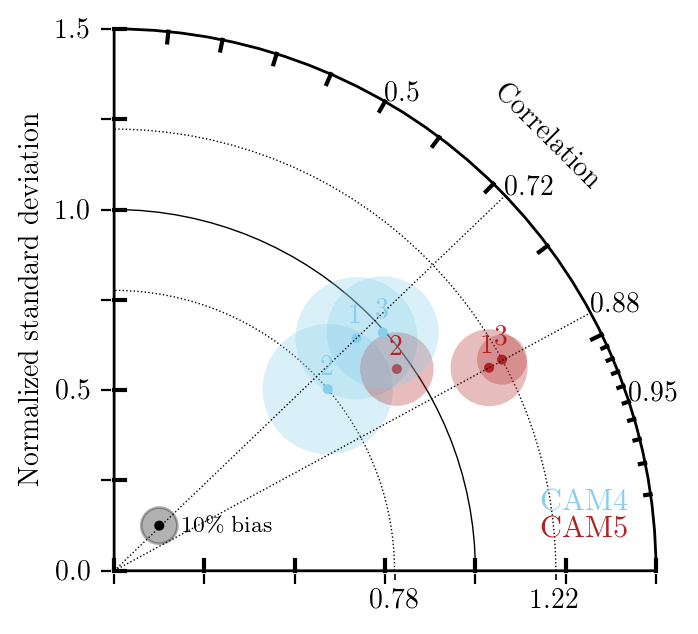

In [116]:
figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )